# Classificando nomes com uma *Character-Level RNN*

Esse notebook foi criado com base no tutorial do PyTorch: <br> 
https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb

### Problema: Dado um nome próprio de entrada, classificar esse nome de acordo com a nacionalidade a que ele pertence.

Entrada: **Hinton**

(-0.47) Scottish

(-1.52) English

(-3.57) Irish


-

Entrada: **Schmidhuber**

(-0.19) German

(-2.48) Czech

(-2.68) Dutch

### Import de bibliotecas

In [1]:
# Para os dados
import unicodedata
import string
import sys, random, os

# Para o processamento e análise
import torch
from torch import nn
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
args = {
    'lr': 5e-5,
    'regularizacao': 1e-7,
    'num_epocas': 40,
}
args['device'] = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dados de entrada

### Importando dataset

In [3]:
# comente as duas linhas seguintes caso rode mais de uma vez
!wget https://download.pytorch.org/tutorial/data.zip #
!unzip data.zip #
############################################################

--2023-05-30 12:20:19--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 54.192.150.110, 54.192.150.27, 54.192.150.53, ...
Connecting to download.pytorch.org (download.pytorch.org)|54.192.150.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.07s   

2023-05-30 12:20:20 (41.9 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/

In [4]:
# Transforma um arquivo de nomes em listas e/ou arrays (nomes, rotulos)
def readLines(filename):
    lines     = open(filename).read().strip().split('\n')
    nomes     = [unicodedata.normalize('NFKD', line).encode('ascii', 'ignore') for line in lines]
    categoria = filename.split('/')[-1].split('.')[0]
    rotulos   = np.repeat( categoria, len(nomes) )

    return nomes, rotulos 


root_path = 'data/names/'
arquivos = sorted(os.listdir(root_path))
categorias = [a[:-4] for a in arquivos]

dados, rotulos = [], []
samples_perclass = []

for file_name in arquivos:
  retorno = readLines(os.path.join(root_path,file_name))
  dados.append(retorno[0])
  rotulos.append(retorno[1])

  samples_perclass.append( (file_name, len(retorno[0])) )


print(samples_perclass, )
print('Minimo amostras', min(samples_perclass, key= lambda k: k[1]), '\n' )

print(dados[categorias.index('Portuguese')][0:10])
print(rotulos[categorias.index('Portuguese')][0:10])

[('Arabic.txt', 2000), ('Chinese.txt', 268), ('Czech.txt', 519), ('Dutch.txt', 297), ('English.txt', 3668), ('French.txt', 277), ('German.txt', 724), ('Greek.txt', 203), ('Irish.txt', 232), ('Italian.txt', 709), ('Japanese.txt', 991), ('Korean.txt', 94), ('Polish.txt', 139), ('Portuguese.txt', 74), ('Russian.txt', 9408), ('Scottish.txt', 100), ('Spanish.txt', 298), ('Vietnamese.txt', 73)]
Minimo amostras ('Vietnamese.txt', 73) 

[b'Abreu', b'Albuquerque', b'Almeida', b'Alves', b'Araujo', b'Araullo', b'Barros', b'Basurto', b'Belo', b'Cabral']
['Portuguese' 'Portuguese' 'Portuguese' 'Portuguese' 'Portuguese'
 'Portuguese' 'Portuguese' 'Portuguese' 'Portuguese' 'Portuguese']


### Convertendo os dados para tensor

**Convertendo os rótulos para tensor**

Representação One-Hot de 18 categorias de idiomas que queremos prever.

In [5]:
def label2tensor(rotulos):
  rotulos_tns = torch.zeros( len(rotulos), 1, dtype=torch.int64 )
  for k, rotulo in enumerate(rotulos):
    idx = categorias.index(rotulo)
    rotulos_tns[k][0] = idx
  return rotulos_tns

rotulos_arabe = rotulos[0]
rotulos_tns = label2tensor(rotulos_arabe)
print(type(rotulos_tns), rotulos_arabe[0], rotulos_tns[0])

<class 'torch.Tensor'> Arabic tensor([0])


**Convertendo os nomes para tensor**

Aqui também usaremos a representação One-Hot, porém teremos que trabalhar com uma lista de tensores, pois os nomes tem comprimentos diferentes. Mais à frente no curso aprenderemos a lidar com isso da forma certa!

In [6]:
caracteres_validos = string.ascii_letters
print(caracteres_validos)
tam_dicionario = len(caracteres_validos)

def nome2tensor(nome):
  tns = torch.zeros( len(nome), tam_dicionario )
  
  for k, letra in enumerate(nome.decode('utf-8')):
    idx = caracteres_validos.find(letra)
    tns[k, idx] = 1

  return tns

dados_arabe = dados[0]
dados_tns = [nome2tensor(dado) for dado in dados_arabe]
print(dados_arabe[0].decode('utf-8')[0],'\n', dados_tns[0][0])


abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ
K 
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


**Amostrando batch balanceado**

In [7]:
num_amostras = min(samples_perclass, key= lambda k: k[1])[1]

def sample_batch(size=num_amostras):
  dados_batch, rotulos_batch = [], []
  for cat in categorias:
    
    amostras_cat = dados[categorias.index(cat)]
    idx = np.random.choice(range(len(amostras_cat)), size=size)
    
    dados_batch.extend([ r for k, r in enumerate(dados[categorias.index(cat)]) if k in idx])
    rotulos_batch.extend([ r for k, r in enumerate(rotulos[categorias.index(cat)]) if k in idx])

  dados_tns = [nome2tensor(dado) for dado in dados_batch]
  return dados_tns, label2tensor(rotulos_batch)

dados_batch, rotulos_batch = sample_batch()
print(len(dados_batch), dados_batch[0].size(), rotulos_batch.size())

1126 torch.Size([8, 52]) torch.Size([1126, 1])


## Modelo Recorrente

* Implemente um modelo para classificação de nomes próprios (série de caracteres) usando apenas camadas *RNNCell*, *Linear* e ativação *LogSoftmax*
* Cada entrada (caracter) possui dimensão (52): alfabeto maiúsculo e minúsculo
* *Hidden size* possui dimensão (256): hiperparâmetro 
* Saída possui dimensão (18): vetor de probabilidade de classes
* Batch size = 1 **pra não termos que lidar com as sequências de tamanho variável.**

### Links úteis

RNNCell: https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html#torch.nn.RNNCell

Linear: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear

Non-linear activations: https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html#torch.nn.LogSoftmax

In [10]:
class RNN(nn.Module):
    def __init__(self, tam_entrada, tam_feature, tam_saida):
        super(RNN, self).__init__()
        
        self.tam_entrada = tam_entrada
        self.tam_feature = tam_feature
        self.tam_saida   = tam_saida
        
        self.rnn    = nn.RNNCell(self.tam_entrada, self.tam_feature)
        self.linear = nn.Linear(self.tam_feature, self.tam_saida)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, nome):
      
        # Inicialize o estado interno da RNN
        hidden = torch.zeros(1, self.tam_feature).to(args['device'])
        
        for letra in nome:
          letra = letra.unsqueeze(0)
          hidden = self.rnn(letra, hidden)
        
        saida = self.linear(hidden)
        saida = self.softmax(saida) 
        return saida

tam_feature = 256
model = RNN(tam_dicionario, tam_feature, len(categorias))
model.to(args['device'])

RNN(
  (rnn): RNNCell(52, 256)
  (linear): Linear(in_features=256, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=None)
)

## Loss e Otimizador

In [13]:
criterion = nn.NLLLoss().to(args['device']) 
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['regularizacao'])

## Treinamento

A otimização é um processo que tem uma raíz muito bem definida de passo a passo, sempre fazemos:
* Carregar os dados e colocar no dispositivo de hardware adequado
* Forward do dado na rede
* Cálculo da função de custo (no nosso caso uma função composta)
* Passos de Otimização
  * Zerar os gradientes do otimizador (`optimizer.zero_grad()`)
  * Calcular os gradientes com base na loss (`loss.backward()`)
  * Passo de otimização (`optimizer.step()`)

Apesar de cada solução ter pequenas variações em um ou mais passos do fluxo, o esqueleto é sempre o mesmo. 

In [14]:
def forward(X, Y, etapa):
  if etapa == 'Treino': model.train()
  else: model.eval()

  acuracia = 0.
  loss_epoca = []
  for k, (dado, rotulo) in enumerate(zip(X, Y)):
      
    dado = dado.to(args['device'])
    rotulo = rotulo.to(args['device'])

    saida = model(dado)
    loss = criterion(saida, rotulo)
    loss_epoca.append(loss.detach().cpu().numpy())

    _, pred = torch.max(saida, axis=-1)
    acuracia += 1 if pred[0].item() == rotulo[0].item() else 0

    if etapa == 'Treino':
      # Otimização
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  loss_epoca = np.asarray(loss_epoca).ravel()
  acuracia   = acuracia/float(len(loss_epoca))
  print('\n','*'*15 + etapa + '*'*15 )
  print('Epoca: {:}, Loss: {:.4f} +/- {:.4f}, Acurácia: {:.4f}'.format(epoca, loss_epoca.mean(), 
                                                                        loss_epoca.std(), 
                                                                        acuracia
                                                                       )) 
  return loss_epoca.mean(), acuracia

In [15]:
loss_treino, loss_test = [], []
acc_treino, acc_test = [], []

dados_test, rotulos_test = sample_batch(size=5)
for epoca in range(200):

  dados_tns, rotulos_tns = sample_batch()

  loss, acuracia = forward(dados_tns, rotulos_tns, 'Treino')
  loss_treino.append(loss)
  acc_treino.append(acuracia)  

  loss, acuracia = forward(dados_test, rotulos_test, 'Teste')
  loss_test.append(loss)
  acc_test.append(acuracia)


<ipython-input-10-84cd394e9f9b>:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  saida = self.softmax(saida)



 ***************Treino***************
Epoca: 0, Loss: 2.7285 +/- 0.6571, Acurácia: 0.1295

 ***************Teste***************
Epoca: 0, Loss: 2.9586 +/- 0.4631, Acurácia: 0.1011

 ***************Treino***************
Epoca: 1, Loss: 2.5595 +/- 0.7515, Acurácia: 0.1478

 ***************Teste***************
Epoca: 1, Loss: 3.0404 +/- 0.7702, Acurácia: 0.1011

 ***************Treino***************
Epoca: 2, Loss: 2.5679 +/- 0.7194, Acurácia: 0.1242

 ***************Teste***************
Epoca: 2, Loss: 3.0074 +/- 0.8963, Acurácia: 0.0787

 ***************Treino***************
Epoca: 3, Loss: 2.5325 +/- 0.7258, Acurácia: 0.1235

 ***************Teste***************
Epoca: 3, Loss: 2.9878 +/- 0.8751, Acurácia: 0.1124

 ***************Treino***************
Epoca: 4, Loss: 2.4990 +/- 0.7143, Acurácia: 0.1516

 ***************Teste***************
Epoca: 4, Loss: 2.9702 +/- 0.8926, Acurácia: 0.1236

 ***************Treino***************
Epoca: 5, Loss: 2.4758 +/- 0.6596, Acurácia: 0.1475

 **

## Análise de Convergência

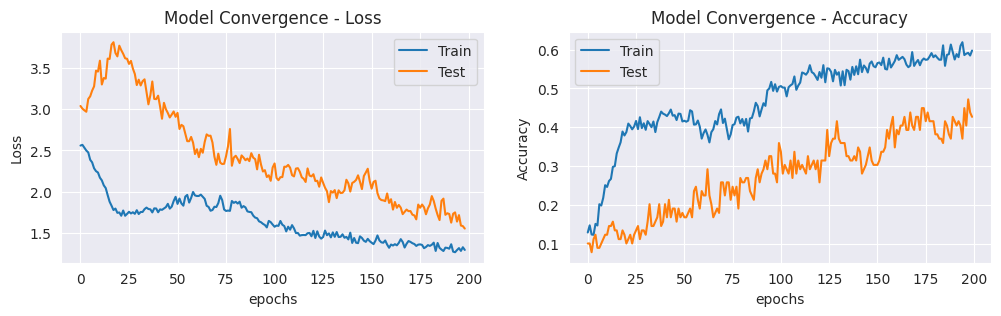

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3))

ax1.plot(loss_treino[1:], label='Train')
ax1.plot(loss_test[1:], label='Test')
ax1.set_title('Model Convergence - Loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(acc_treino, label='Train')
ax2.plot(acc_test, label='Test')
ax2.set_title('Model Convergence - Accuracy')
ax2.set_xlabel('epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

## Usando o modelo

In [17]:
def predict(nome):
  model.eval()

  tns = torch.zeros( len(nome), tam_dicionario )
  for k, letra in enumerate(nome):
    idx = caracteres_validos.find(letra)
    tns[k, idx] = 1
  tns = tns.to(args['device'])

  saida = model(tns)
  topv, topi = saida.data.topk(3, 1, True)

  print(nome)
  for value, index in zip(topv[0], topi[0]):
    print('(%.2f) %s' % (value, categorias[index]))
  print('\n')
  
predict('Mota')
predict('Kamikaze')
predict('Suarez')

Mota
(-1.33) Japanese
(-1.56) Spanish
(-1.77) Portuguese


Kamikaze
(-0.61) Japanese
(-2.14) Scottish
(-2.28) English


Suarez
(-0.41) Spanish
(-1.56) Portuguese
(-3.48) Dutch




<ipython-input-10-84cd394e9f9b>:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  saida = self.softmax(saida)
